In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [2]:
import tensorflow as tf

2023-03-20 16:43:48.057193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
## 1. Load the datasets

In [4]:
# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

In [ ]:
# For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in clean_noisy_trainset. 
#You are encouraged to explore more characteristics of the label nois

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


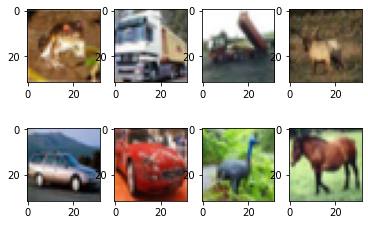

In [5]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


In [6]:
# Split images
clean_img = imgs[:10000]
noisy_img = imgs[10000:]

In [7]:
clean_img = clean_img/255
noisy_img = noisy_img/255

print(clean_img.shape)
print(noisy_img.shape)

(10000, 32, 32, 3)
(40000, 32, 32, 3)


In [8]:
print(imgs.shape)
print(noisy_labels.shape)
print(clean_labels.shape)
print(np.unique(noisy_labels))

(50000, 32, 32, 3)
(50000,)
(10000,)
[0 1 2 3 4 5 6 7 8 9]


In [9]:
test = imgs[0]
print('Class:', type(test))
print('Dimensions:', test.shape)
print('Data Type:', test.dtype)
print('Head:', test[:3, :3])
print('Range', np.min(test), np.max(test))

Class: <class 'numpy.ndarray'>
Dimensions: (32, 32, 3)
Data Type: float64
Head: [[[59. 62. 63.]
  [43. 46. 45.]
  [50. 48. 43.]]

 [[16. 20. 20.]
  [ 0.  0.  0.]
  [18.  8.  0.]]

 [[25. 24. 21.]
  [16.  7.  0.]
  [49. 27.  8.]]]
Range 0.0 255.0


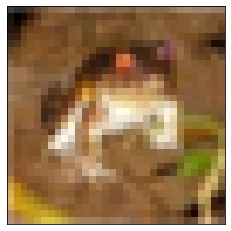

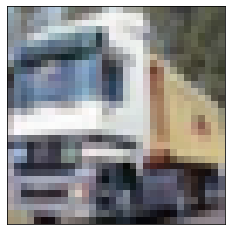

In [10]:
for i in range(2):
    plt.imshow(imgs[i]/255)
    plt.xticks([]) ## remove the ticks on x-axis
    plt.yticks([])
    plt.show()

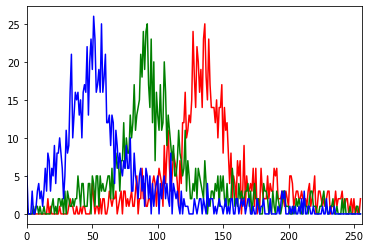

In [11]:
x = imgs[0].astype(np.uint8)
color = ('r','g','b')
for i, col in enumerate(color):
    histr = cv2.calcHist([x],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

In [12]:
# Display shapes
print('Number of noisy labels:', noisy_labels.shape[0])
print('Number of clean labels:', clean_labels.shape[0])

Number of noisy labels: 50000
Number of clean labels: 10000


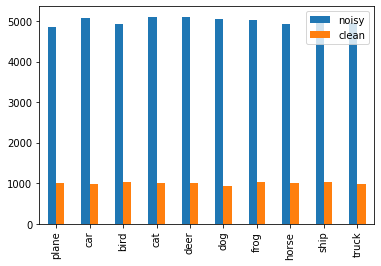

In [13]:
# Visualize number of noisy and clean labels
import pandas as pd

_, noisy_counts = np.unique(noisy_labels,return_counts=True)
_, clean_counts = np.unique(clean_labels,return_counts=True)
pd.DataFrame({
    'noisy': noisy_counts,
    'clean': clean_counts},
    index = classes
).plot.bar()

plt.show()

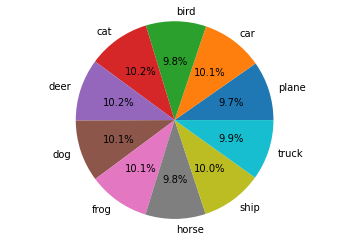

In [14]:
# Visualize proportion of categories
plt.pie(
    noisy_counts,
    explode = (0,0,0,0,0,0,0,0,0,0),
    labels = classes,
    autopct = '%1.1f%%')
plt.axis('equal')
plt.show()

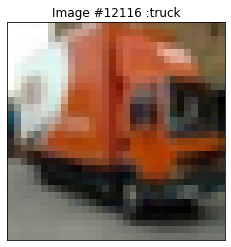

In [15]:
# Get a random image
def display_random_img(classes,images,labels):
    index = np.random.randint(imgs.shape[0])
    plt.figure()
    plt.imshow(imgs[index]/255)
    plt.xticks([])
    plt.yticks([])
    plt.title('Image #{} :'.format(index) + classes[labels[index]])
    plt.show()
    
display_random_img(classes,imgs,noisy_labels)

In [ ]:
# 2. The pridictive model

In [ ]:
# 2.1 Baseline model

In [16]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [17]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

In [18]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

In [ ]:
# 2.2 Model I

In [ ]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# write your code here...

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

In [ ]:
# 2.3 Model II

In [33]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

In [ ]:
# My model (test)

In [20]:
import time
# Copied Srushti's for calculating time and accuracy

In [23]:
# CNN w/ 4 layers
tf.random.set_seed(123)
start = time.time()

my_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),padding="same", activation = 'relu', input_shape = [32, 32, 3]), 
    tf.keras.layers.MaxPooling2D(2,2,padding='valid'),
    tf.keras.layers.Conv2D(32,(3,3),padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2,padding='valid'),
    tf.keras.layers.Conv2D(64,(3,3),padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2,padding='valid'),
    tf.keras.layers.Conv2D(128,(3,3),padding="same", activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2,padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(550, activation = tf.nn.relu),
    tf.keras.layers.Dropout(0.1,seed = 123),
    tf.keras.layers.Dense(400,activation = tf.nn.relu),
    tf.keras.layers.Dropout(0.3,seed = 123),
    tf.keras.layers.Dense(300,activation= tf.nn.relu),
    tf.keras.layers.Dropout(0.4,seed = 123),
    tf.keras.layers.Dense(200,activation = tf.nn.relu),
    tf.keras.layers.Dropout(0.2,seed = 123),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])


In [24]:
my_model.compile(
    optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy'])

In [25]:
train_labels = noisy_labels[10000:]
my_model.fit(noisy_img, train_labels, epochs = 8)

Epoch 1/8
1250/1250 [==============================] - 36s 28ms/step - loss: 2.3032 - accuracy: 0.1002
Epoch 2/8
1250/1250 [==============================] - 35s 28ms/step - loss: 2.3028 - accuracy: 0.1001
Epoch 3/8
1250/1250 [==============================] - 33s 26ms/step - loss: 2.3027 - accuracy: 0.1000
Epoch 4/8
1250/1250 [==============================] - 36s 29ms/step - loss: 2.3027 - accuracy: 0.0993
Epoch 5/8
1250/1250 [==============================] - 36s 28ms/step - loss: 2.3026 - accuracy: 0.1014
Epoch 6/8
1250/1250 [==============================] - 37s 29ms/step - loss: 2.3026 - accuracy: 0.1023
Epoch 7/8
1250/1250 [==============================] - 37s 29ms/step - loss: 2.3026 - accuracy: 0.0988
Epoch 8/8
1250/1250 [==============================] - 36s 29ms/step - loss: 2.3026 - accuracy: 0.1017


In [26]:
test_loss,test_accuracy = my_model.evaluate(clean_img, clean_labels)

end = time.time()

print("time taken (in mins) to run code: ", (end - start)/60)
print("test accuracy: ", test_accuracy)

313/313 [==============================] - 4s 10ms/step - loss: 2.3028 - accuracy: 0.0999
time taken (in mins) to run code:  5.3418275554974874
test accuracy:  0.09989999979734421


In [27]:

tf.random.set_seed(123)
start = time.time()

my_model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu',input_shape = [32, 32, 3])),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2,seed = 123),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
    ])

my_model_2.compile(
    optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy'])

my_model_2.fit(noisy_img, train_labels, epochs = 8)

test_loss,test_accuracy = my_model.evaluate(clean_img, clean_labels)

end = time.time()

print("time taken (in mins) to run code: ", (end - start)/60)
print("test accuracy: ", test_accuracy)

Epoch 1/8
1250/1250 [==============================] - 35s 28ms/step - loss: 2.3026 - accuracy: 0.1006
Epoch 2/8
1250/1250 [==============================] - 34s 27ms/step - loss: 2.3026 - accuracy: 0.1010
Epoch 3/8
1250/1250 [==============================] - 33s 27ms/step - loss: 2.3027 - accuracy: 0.1010
Epoch 4/8
1250/1250 [==============================] - 32s 25ms/step - loss: 2.3027 - accuracy: 0.1002
Epoch 5/8
1250/1250 [==============================] - 35s 28ms/step - loss: 2.3026 - accuracy: 0.0996
Epoch 6/8
1250/1250 [==============================] - 34s 27ms/step - loss: 2.3026 - accuracy: 0.1026
Epoch 7/8
1250/1250 [==============================] - 33s 26ms/step - loss: 2.3026 - accuracy: 0.0989
Epoch 8/8
313/313 [==============================] - 3s 10ms/step - loss: 2.3028 - accuracy: 0.0999
time taken (in mins) to run code:  4.58738028605779
test accuracy:  0.09989999979734421


In [31]:
tf.random.set_seed(123)
start = time.time()

my_model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), padding='same', activation = 'relu',input_shape = [32, 32, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3), padding='same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64,(3,3), padding='same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3), padding='same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3), padding='same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3), padding='same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

my_model_3.compile(
    optimizer = 'adam', 
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy'])

my_model_3.fit(noisy_img, train_labels, epochs = 8)

test_loss,test_accuracy = my_model_3.evaluate(clean_img, clean_labels)

end = time.time()

print("time taken (in mins) to run code: ", (end - start)/60)
print("test accuracy: ", test_accuracy)

Epoch 1/8
1250/1250 [==============================] - 191s 151ms/step - loss: 2.9032 - accuracy: 0.1289
Epoch 2/8
1250/1250 [==============================] - 196s 157ms/step - loss: 2.5323 - accuracy: 0.1552
Epoch 3/8
1250/1250 [==============================] - 183s 146ms/step - loss: 2.3603 - accuracy: 0.1839
Epoch 4/8
1250/1250 [==============================] - 179s 143ms/step - loss: 2.2696 - accuracy: 0.1997
Epoch 5/8
1250/1250 [==============================] - 179s 143ms/step - loss: 2.2280 - accuracy: 0.2156
Epoch 6/8
1250/1250 [==============================] - 178s 143ms/step - loss: 2.2045 - accuracy: 0.2297
Epoch 7/8
1250/1250 [==============================] - 179s 143ms/step - loss: 2.1937 - accuracy: 0.2378
Epoch 8/8
313/313 [==============================] - 16s 50ms/step - loss: 1.7301 - accuracy: 0.4828
time taken (in mins) to run code:  24.974117449919383
test accuracy:  0.4828000068664551


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

history = my_model_3.fit(datagen.flow(noisy_img, train_labels), 
                    epochs=8, validation_data=(noisy_img, train_labels), 
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/8
1250/1250 [==============================] - 262s 209ms/step - loss: 2.1965 - accuracy: 0.2396 - val_loss: 2.2151 - val_accuracy: 0.2198
Epoch 2/8
1250/1250 [==============================] - 262s 209ms/step - loss: 2.1902 - accuracy: 0.2462 - val_loss: 2.1541 - val_accuracy: 0.2693
Epoch 3/8
1250/1250 [==============================] - 276s 221ms/step - loss: 2.1822 - accuracy: 0.2540 - val_loss: 2.1576 - val_accuracy: 0.2695
Epoch 4/8
1250/1250 [==============================] - 279s 223ms/step - loss: 2.1803 - accuracy: 0.2534 - val_loss: 2.1496 - val_accuracy: 0.2712
Epoch 5/8
1250/1250 [==============================] - 282s 226ms/step - loss: 2.1748 - accuracy: 0.2612 - val_loss: 2.1454 - val_accuracy: 0.2755
Epoch 6/8
1250/1250 [==============================] - 271s 217ms/step - loss: 2.1684 - accuracy: 0.2634 - val_loss: 2.1491 - val_accuracy: 0.2743
Epoch 7/8
1250/1250 [==============================] - 307s 246ms/step - loss: 2.1665 - accuracy: 0.2653 - val_loss: 2

In [36]:
test_loss, test_acc = my_model_3.evaluate(clean_img, clean_labels)
print('Test accuracy:', test_acc)

313/313 [==============================] - 16s 51ms/step - loss: 1.5169 - accuracy: 0.6136
Test accuracy: 0.6136000156402588
